In [23]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv
/kaggle/input/icr-identify-age-related-conditions/greeks.csv
/kaggle/input/icr-identify-age-related-conditions/train.csv
/kaggle/input/icr-identify-age-related-conditions/test.csv


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings("ignore")

In [25]:
data = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv', index_col='Id')
data

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
Id,,,,,,,,,,,,,,,,,,,,,
000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,...,0.173229,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,0
fd895603f071,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,5654.07556,...,10.223150,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340,0
fd8ef6377f76,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,5888.87769,...,0.173229,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000,0


In [26]:
data.isna().sum()


AB        0
AF        0
AH        0
AM        0
AR        0
AX        0
AY        0
AZ        0
BC        0
BD        0
BN        0
BP        0
BQ       60
BR        0
BZ        0
CB        2
CC        3
CD        0
CF        0
CH        0
CL        0
CR        0
CS        0
CU        0
CW        0
DA        0
DE        0
DF        0
DH        0
DI        0
DL        0
DN        0
DU        1
DV        0
DY        0
EB        0
EE        0
EG        0
EH        0
EJ        0
EL       60
EP        0
EU        0
FC        1
FD        0
FE        0
FI        0
FL        1
FR        0
FS        2
GB        0
GE        0
GF        0
GH        0
GI        0
GL        1
Class     0
dtype: int64

In [27]:
#quantifying categorical variable EJ
data.EJ=data.EJ.map({'A':0, 'B':1})

#filling missing values of features that have a few of them, for BQ and EL we will make regression models for prediction
data_na = data.drop(['EL', 'BQ'], axis=1)
imputer = SimpleImputer(strategy='median').fit(data_na)
data_na = pd.DataFrame(imputer.transform(data_na),columns=data_na.columns, index=data_na.index)
data_na = pd.concat([data_na, data[['BQ','EL']]], axis=1)
data_post = data_na.copy()
data_post


,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FS,GB,GE,GF,GH,GI,GL,Class,BQ,EL
Id,,,,,,,,,,,,,,,,,,,,,
000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1.0,152.707705,30.879420
007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0.0,14.754720,109.125159
013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0.0,219.320160,109.125159
043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0.0,11.050410,31.674357
044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1.0,149.717165,109.125159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,...,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,0.0,27.287375,51.618996
fd895603f071,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,5654.07556,...,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340,0.0,344.644105,109.125159
fd8ef6377f76,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,5888.87769,...,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000,0.0,103.988995,109.125159


In [28]:
data_post.BQ = data_post.BQ.fillna(0)

In [29]:
#EL datasets
train_el_df = data_post[~data_post.EL.isna()]
X_train_el_df=train_el_df.drop(['BQ', 'EL', 'Class'], axis=1)
y_train_el_df=train_el_df.EL

test_el_df = data_post[data_post.EL.isna()]
X_test_el_df=test_el_df.drop(['EL', 'Class'], axis=1)


#making grid for hyperparamters optimization for feature selection
el_grid_fs = GridSearchCV(XGBRegressor(), param_grid={'n_estimators':[50,80,100], 'eta': [0.001, 0.005, 0.01, 0.03, 0.1, 1]},
                           n_jobs=-1, cv=10, verbose=1,scoring='neg_mean_squared_error')
el_grid_fs.fit(X_train_el_df, y_train_el_df)

#making model for features selection
el_model_fs = XGBRegressor(n_estimators=el_grid_fs.best_params_['n_estimators'], eta=el_grid_fs.best_params_['eta'])
el_model_fs.fit(X_train_el_df, y_train_el_df)

#chosing 10 most important features
feature_importances = el_model_fs.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
features_el = sorted_indices[:10]

X_train_el_df = X_train_el_df.iloc[:,features_el]
X_test_el_df = X_test_el_df.iloc[:,features_el]

#making grid for hyperparamters optimization for prediction
el_grid = GridSearchCV(XGBRegressor(), param_grid={'n_estimators':[50,80,100], 'eta': [0.001, 0.005, 0.01, 0.03, 0.1, 1]},
                           n_jobs=-1, cv=10, verbose=1,scoring='neg_mean_squared_error')
el_grid.fit(X_train_el_df, y_train_el_df)

#making model for prediction
el_model = XGBRegressor(n_estimators=el_grid.best_params_['n_estimators'], eta=el_grid.best_params_['eta'])
el_model.fit(X_train_el_df, y_train_el_df)

el_pred=el_model.predict(X_test_el_df)
data_post.loc[data_post.EL.isna(), 'EL']=el_pred

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Fitting 10 folds for each of 18 candidates, totalling 180 fits


In [30]:
data_post


,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FS,GB,GE,GF,GH,GI,GL,Class,BQ,EL
Id,,,,,,,,,,,,,,,,,,,,,
000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1.0,152.707705,30.879420
007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0.0,14.754720,109.125159
013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0.0,219.320160,109.125159
043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0.0,11.050410,31.674357
044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1.0,149.717165,109.125159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,...,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,0.0,27.287375,51.618996
fd895603f071,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,5654.07556,...,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340,0.0,344.644105,109.125159
fd8ef6377f76,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,5888.87769,...,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000,0.0,103.988995,109.125159


In [31]:
test=pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')
test_helper = test[['BQ', 'EL']]
test.EJ=test.EJ.map({'A':0, 'B':1})
test=test.drop(['BQ', 'EL'], axis=1)
new_test = test.drop('Id', axis=1)
new_test = pd.concat([new_test, test_helper], axis=1)
new_test.BQ = new_test.BQ.fillna(0)
new_test.fillna(new_test.median(), inplace=True)
new_test

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FR,FS,GB,GE,GF,GH,GI,GL,BQ,EL
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
data_transform.isna().sum()

AB      0
AF      0
AH      0
AM      0
AR      0
AX      0
AY      0
AZ      0
BC      0
BD      0
BN      0
BP      0
BR      0
BZ      0
CB      0
CC      0
CD      0
CF      0
CH      0
CL      0
CR      0
CS      0
CU      0
CW      0
DA      0
DE      0
DF      0
DH      0
DI      0
DL      0
DN      0
DU      0
DV      0
DY      0
EB      0
EE      0
EG      0
EH      0
EJ      0
EP      0
EU      0
FC      0
FD      0
FE      0
FI      0
FL      0
FR      0
FS      0
GB      0
GE      0
GF      0
GH      0
GI      0
GL      0
BQ     60
EL      0
dtype: int64

#New Features

In [33]:
poly_train = PolynomialFeatures()
data_transform = data_post.drop('Class', axis=1).copy()
data_poly = pd.DataFrame(poly_train.fit_transform(data_transform),
                         columns=poly_train.get_feature_names_out(), index=data_transform.index)
data_poly=data_poly.drop('1', axis=1)
data_poly=pd.concat([data_poly, data_post[['Class']]], axis=1)
data_poly.Class = data_poly.Class.astype('int64')
data_poly

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,GI GL,GI BQ,GI EL,GL^2,GL BQ,GL EL,BQ^2,BQ EL,EL^2,Class
Id,,,,,,,,,,,,,,,,,,,,,
000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,8.404137,10664.334027,2156.462566,0.014482,18.377282,3.716118,23319.643166,4715.525360,953.538580,1
007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,706.197008,474.098604,3506.409172,483.032484,324.279236,2398.352745,217.701762,1610.111166,11908.300327,0
013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,6.930887,7718.463331,3840.406364,0.038786,43.193170,21.491237,48101.332582,23933.347332,11908.300327,0
043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,14.101434,999.987493,2866.315443,0.024283,1.721970,4.935770,122.111561,350.014631,1003.264891,0
044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,3.503494,5429.137860,3957.165046,0.009334,14.464843,10.543068,22415.229496,16337.909436,11908.300327,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,...,1520.700545,1888.066523,3571.618681,483.032484,599.721928,1134.482294,744.600834,1408.546901,2664.520748,0
fd895603f071,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,5654.07556,...,18.139775,43014.641986,13619.788002,0.021124,50.090721,15.860297,118779.559111,37609.342757,11908.300327,0
fd8ef6377f76,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,5888.87769,...,2627.676933,12432.863929,13046.940717,483.032484,2285.470132,2398.352745,10813.711081,11347.815614,11908.300327,0


In [34]:
poly_test = PolynomialFeatures()
test_poly = pd.DataFrame(poly_test.fit_transform(new_test), columns=poly_test.get_feature_names_out())
test_poly = test_poly.drop('1', axis=1)
test_poly

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,GI^2,GI GL,GI BQ,GI EL,GL^2,GL BQ,GL EL,BQ^2,BQ EL,EL^2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Feature Selection

In [38]:
!pip -q install featurewiz #--no-index --find-links=file:///kaggle/input/featurewiz

Imported 0.3.2 version. Select nrows to a small number when running on huge datasets.
output = featurewiz(dataname, target, corr_limit=0.90, verbose=2, sep=',', 
		header=0, test_data='',feature_engg='', category_encoders='',
		dask_xgboost_flag=False, nrows=None, skip_sulov=False, skip_xgboost=False)
Create new features via 'feature_engg' flag : ['interactions','groupby','target']

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.5 as the correlation limit. Change this limit to fit your needs...
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_L

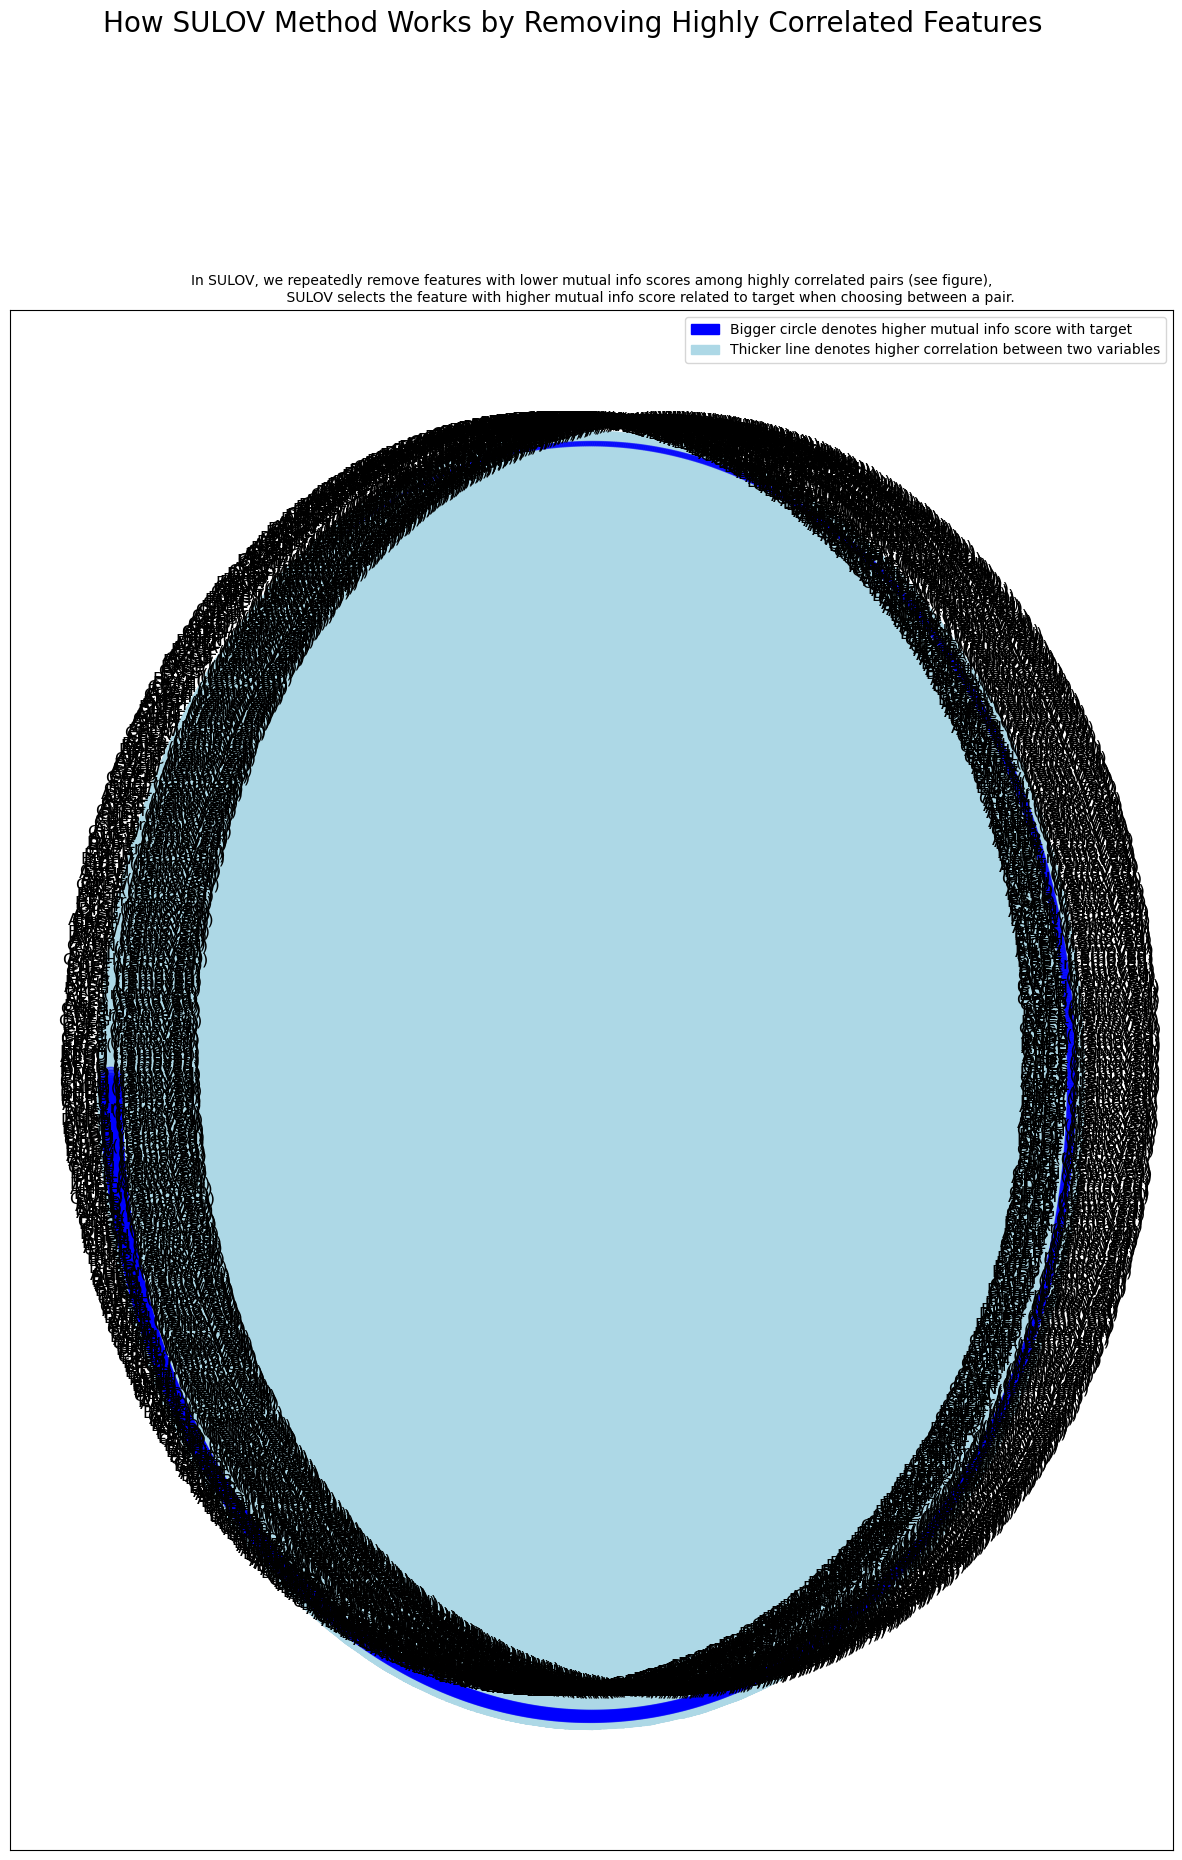

Time taken for SULOV method = 86 seconds
    Adding 0 categorical variables to reduced numeric variables  of 73
Finally 73 vars selected after SULOV
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
    Taking top 330 features per iteration...
    XGBoost version using 1.7.6 as tree method: hist
    Number of booster rounds = 100
            Time taken for regular XGBoost feature selection = 0 seconds
            Time taken for regular XGBoost feature selection = 0 seconds
            Time taken for regular XGBoost feature selection = 0 seconds
        Selected: ['FI', 'DNFD', 'FCBQ', 'CD2', 'DN', 'AXCR', 'CBGE', 'CLEL', 'AFAH', 'DADY', 'CUDL', 'AFCW', 'AMGF', 'ABDA', 'ABCW', 'DAEG', 'BN

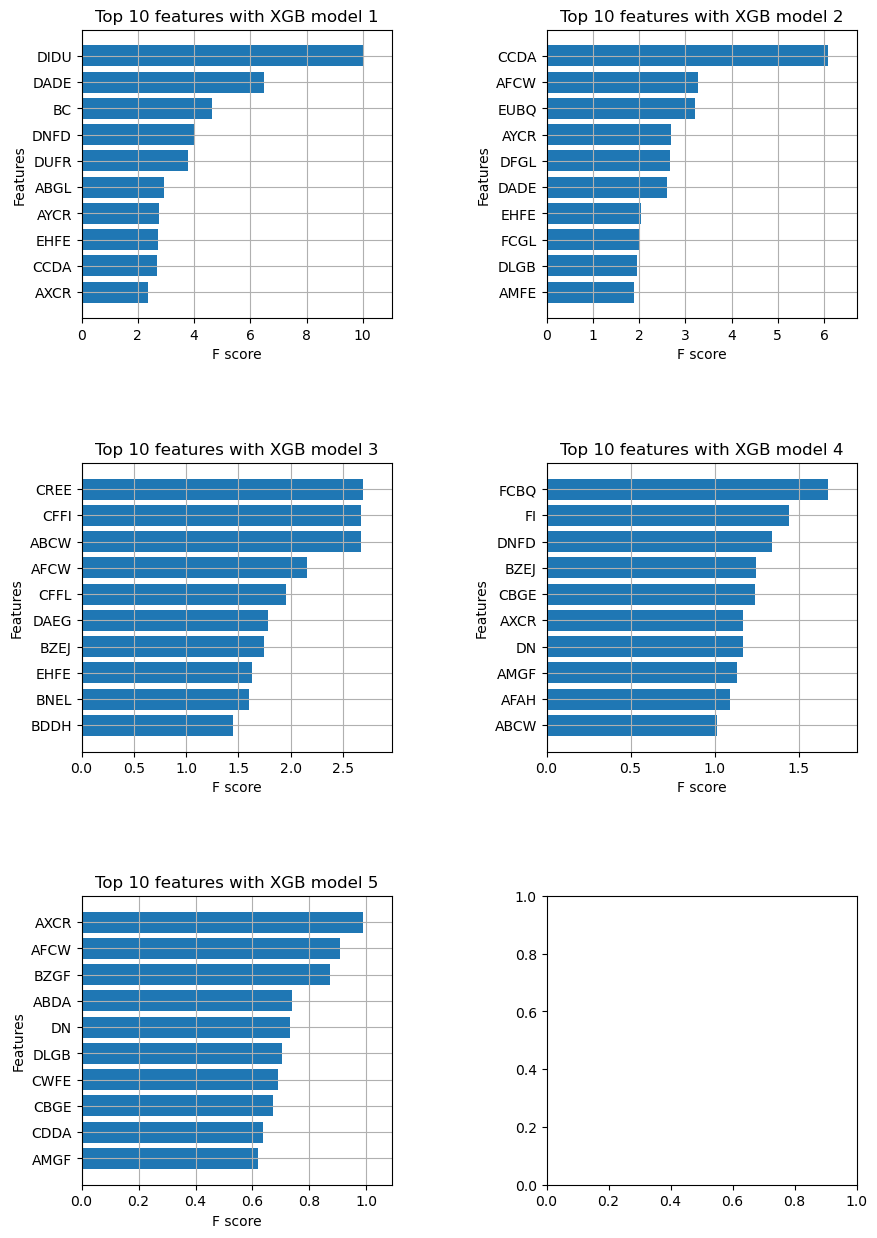

    Completed XGBoost feature selection in 3 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 73 important features. Too many to print...
Total Time taken for featurewiz selection = 90 seconds
Output contains a list of 73 important features and a train dataframe


In [39]:
from featurewiz import featurewiz
out1, _ = featurewiz(data_poly, 'Class', corr_limit=0.5, verbose=2)

In [40]:
data_sel = data_poly[out1]
data_sel['Class']=data_poly.Class
data_sel

,DI DU,DU FR,DA DE,AB GL,CL BQ,BC,CC DA,AM FE,AB DA,CD DY,...,CR CW,FE GF,FC GL,AF CW,FC FL,BN^2,AZ CC,BZ GF,BZ EJ,Class
Id,,,,,,,,,,,,,,,,,,,,,
000ff2bfdfe9,473.955503,9.232900,20419.020261,0.025197,160.377449,5.555634,38.927158,202183.243794,14.464475,542.304746,...,2.506357,1.809098e+07,1.611949,112565.522500,97.756252,510.687683,5.528993,5.158457e+05,257.432377,1
007255e47698,0.610146,0.002743,12641.266653,3.193008,16.434914,1.229900,34.316682,250834.040295,10.285727,871.935604,...,41.891308,1.898550e+08,377.493776,36680.721598,2.975379,377.155820,6.552210,7.203360e+06,0.000000,0
013f2bd269f5,154.841470,1.258218,22763.337155,0.092568,230.335515,1.229900,35.116060,269851.615432,33.287384,3168.431371,...,15.029262,1.140509e+08,44.155674,56548.448250,1728.540612,701.322806,6.359083,3.520892e+06,257.432377,0
043ac50845d5,371.282473,1.319866,9294.811574,0.039285,15.473889,1.229900,33.938495,845594.376927,11.918575,4584.629131,...,13.694944,2.296519e+07,9.240943,82238.599912,363.056342,559.686769,7.935259,5.391310e+05,257.432377,0
044fb8a146ec,112.108941,55.529281,14826.259477,0.036742,157.236710,102.151980,39.733597,228453.047528,28.166819,658.509792,...,23.855007,1.380782e+08,2.811736,128474.205960,237.275502,576.518517,1.822259,2.194449e+06,257.432377,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fd3dafe738fd,0.976492,0.006957,7744.715234,3.286920,32.131566,2.804172,15.041090,163328.557554,3.254173,1793.272903,...,4.909144,1.389846e+08,652.924886,22006.321242,5.146307,448.846596,5.907146,2.084155e+06,0.000000,0
fd895603f071,124.865123,0.805444,6911.151730,0.063346,361.953855,3.777550,33.911847,859346.951983,19.137980,1551.009629,...,25.607240,5.695581e+07,10.078440,183788.477302,708.910828,739.225408,9.748724,7.942582e+05,257.432377,0
fd8ef6377f76,1.207891,0.002743,23352.209038,9.391199,155.544139,1.229900,74.135679,281701.286976,44.704263,6784.774147,...,32.383874,3.294901e+07,1576.384885,90512.791513,12.424951,419.422208,10.918638,1.666785e+06,0.000000,0


hyper parameter optimization

In [41]:
from sklearn.metrics import make_scorer

def competition_log_loss(y_true, y_pred):
    
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    
    w_0 = 1 / N_0
    w_1 = 1 / N_1
    
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0)) / N_0
    log_loss_1 = -np.sum(y_true * np.log(p_1)) / N_1
    
    return (log_loss_0 + log_loss_1)/2

def balanced_log_loss(y_true, y_pred):

    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)

    w_0 = 1 / N_0
    w_1 = 1 / N_1

    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1

    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0))
    log_loss_1 = -np.sum(y_true * np.log(p_1))

    balanced_log_loss = 2*(w_0 * log_loss_0 + w_1 * log_loss_1) / (w_0 + w_1)

    return balanced_log_loss/(N_0+N_1)

cll = make_scorer(competition_log_loss, greater_is_better=False, needs_proba=True)
bll = make_scorer(balanced_log_loss, greater_is_better=False, needs_proba=True)

In [42]:
#xgboost, tree, lgbm, random forest, gb, stack
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score


X = data_sel.drop('Class', axis=1)
y = data_sel['Class']

In [43]:
gridLGBM_1 = GridSearchCV(LGBMClassifier(), {'learning_rate': [0.01, 0.05, 0.1, 0.26, 0.3, 0.5, 1],
                                        'n_estimators': [50,80,100,200], 'num_leaves': [8,10,14,20,26,31],
                                       'max_depth': [-1,2,4,6,8,10]},
                                        cv=KFold(n_splits=5, shuffle=True, random_state=12), n_jobs=-1,
                        scoring='neg_log_loss', verbose=1)
gridLGBM_1.fit(X, y)
print(f'Best hyperparameters: {gridLGBM_1.best_params_}')

modelLGBM_1 = LGBMClassifier(n_estimators=gridLGBM_1.best_params_['n_estimators'],
                        learning_rate=gridLGBM_1.best_params_['learning_rate'],
                        num_leaves=gridLGBM_1.best_params_['num_leaves'],
                        max_depth=gridLGBM_1.best_params_['max_depth'],
                        objective = 'binary',
                        class_weight = 'balanced',
                        random_state=12)

Fitting 5 folds for each of 1008 candidates, totalling 5040 fits


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 80, 'num_leaves': 10}


In [44]:
#making few indepedent grids for LGBM to reduce time spent on searching for best hyperparams fits
gridLGBM_2 = GridSearchCV(modelLGBM_1, {'subsample': [0.1, 0.3, 0.5, 0.7, 0.9, 1], 
                                          'colsample_bytree': [0.1, 0.3, 0.5, 0.7, 0.9, 1],
                                       'subsample_freq': [0,1,3,5,8,10]},
                          cv = KFold(n_splits=5, shuffle=True, random_state=12),
                          n_jobs=-1, scoring='neg_log_loss', verbose=1)
gridLGBM_2.fit(X, y)
print(f'Best hyperparameters: {gridLGBM_2.best_params_}')

modelLGBM_2 = LGBMClassifier(n_estimators=gridLGBM_1.best_params_['n_estimators'],
                        learning_rate=gridLGBM_1.best_params_['learning_rate'],
                        num_leaves=gridLGBM_1.best_params_['num_leaves'],
                        max_depth=gridLGBM_1.best_params_['max_depth'],
                        subsample = gridLGBM_2.best_params_['subsample'],
                        colsample_bytree = gridLGBM_2.best_params_['colsample_bytree'],
                        subsample_freq = gridLGBM_2.best_params_['subsample_freq'],
                        objective = 'binary',
                        class_weight = 'balanced',
                        random_state=12)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best hyperparameters: {'colsample_bytree': 0.3, 'subsample': 0.9, 'subsample_freq': 3}


In [45]:
gridLGBM_3 = GridSearchCV(modelLGBM_2, {'min_split_gain': [0, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 1],
                                          'min_child_weight' : [0.0005, 0.001, 0.005, 0.01, 0.03, 0.05, 0.1],
                                          'min_child_samples':[5,10,15,20, 25,30]},
                          cv = KFold(n_splits=5, shuffle=True, random_state=12),
                          n_jobs=-1, scoring='neg_log_loss', verbose=1)
gridLGBM_3.fit(X, y)
print(f'Best hyperparameters: {gridLGBM_3.best_params_}')

modelLGBM_3 = LGBMClassifier(n_estimators=gridLGBM_1.best_params_['n_estimators'],
                        learning_rate=gridLGBM_1.best_params_['learning_rate'],
                        num_leaves=gridLGBM_1.best_params_['num_leaves'],
                        max_depth=gridLGBM_1.best_params_['max_depth'],
                        subsample = gridLGBM_2.best_params_['subsample'],
                        colsample_bytree = gridLGBM_2.best_params_['colsample_bytree'],
                        subsample_freq = gridLGBM_2.best_params_['subsample_freq'], 
                        min_split_gain = gridLGBM_3.best_params_['min_split_gain'],
                        min_child_weight = gridLGBM_3.best_params_['min_child_weight'],
                        min_child_samples = gridLGBM_3.best_params_['min_child_samples'],
                        objective = 'binary',
                        class_weight = 'balanced',
                        random_state=12)

Fitting 5 folds for each of 336 candidates, totalling 1680 fits
Best hyperparameters: {'min_child_samples': 20, 'min_child_weight': 0.0005, 'min_split_gain': 0.1}


In [46]:
gridLGBM_4 = GridSearchCV(modelLGBM_3, {'reg_lambda': [0, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 1],
                                          'reg_alpha' : [0, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 1]},
                          cv = KFold(n_splits=5, shuffle=True, random_state=12),
                          n_jobs=-1, scoring='neg_log_loss', verbose=1)
gridLGBM_4.fit(X, y)
print(f'Best hyperparameters: {gridLGBM_4.best_params_}')

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best hyperparameters: {'reg_alpha': 0.1, 'reg_lambda': 0.01}


modeling and evaluation

In [47]:
modelLGBM_4 = LGBMClassifier(n_estimators=gridLGBM_1.best_params_['n_estimators'],
                        learning_rate=gridLGBM_1.best_params_['learning_rate'],
                        num_leaves=gridLGBM_1.best_params_['num_leaves'],
                        max_depth=gridLGBM_1.best_params_['max_depth'],
                        subsample = gridLGBM_2.best_params_['subsample'],
                        colsample_bytree = gridLGBM_2.best_params_['colsample_bytree'],
                        subsample_freq = gridLGBM_2.best_params_['subsample_freq'],
                        min_split_gain = gridLGBM_3.best_params_['min_split_gain'],
                        min_child_weight = gridLGBM_3.best_params_['min_child_weight'],
                        min_child_samples = gridLGBM_3.best_params_['min_child_samples'],
                        reg_lambda = gridLGBM_4.best_params_['reg_lambda'],
                        reg_alpha = gridLGBM_4.best_params_['reg_alpha'],
                        objective = 'binary',
                        class_weight = 'balanced',
                        random_state=12)

In [48]:
modelLGBM_4.fit(X, y)

results_lgbm = cross_val_score(modelLGBM_4, X, y, cv=10, n_jobs=-1, scoring=bll).mean()
results_lgbm_acc = cross_val_score(modelLGBM_4, X, y, cv=10, n_jobs=-1, scoring='accuracy').mean()

print(f'LGBM: bll = {results_lgbm}, accuracy = {results_lgbm_acc}')

LGBM: bll = -0.15974724720783742, accuracy = 0.9384717080909573


Feature Importance 

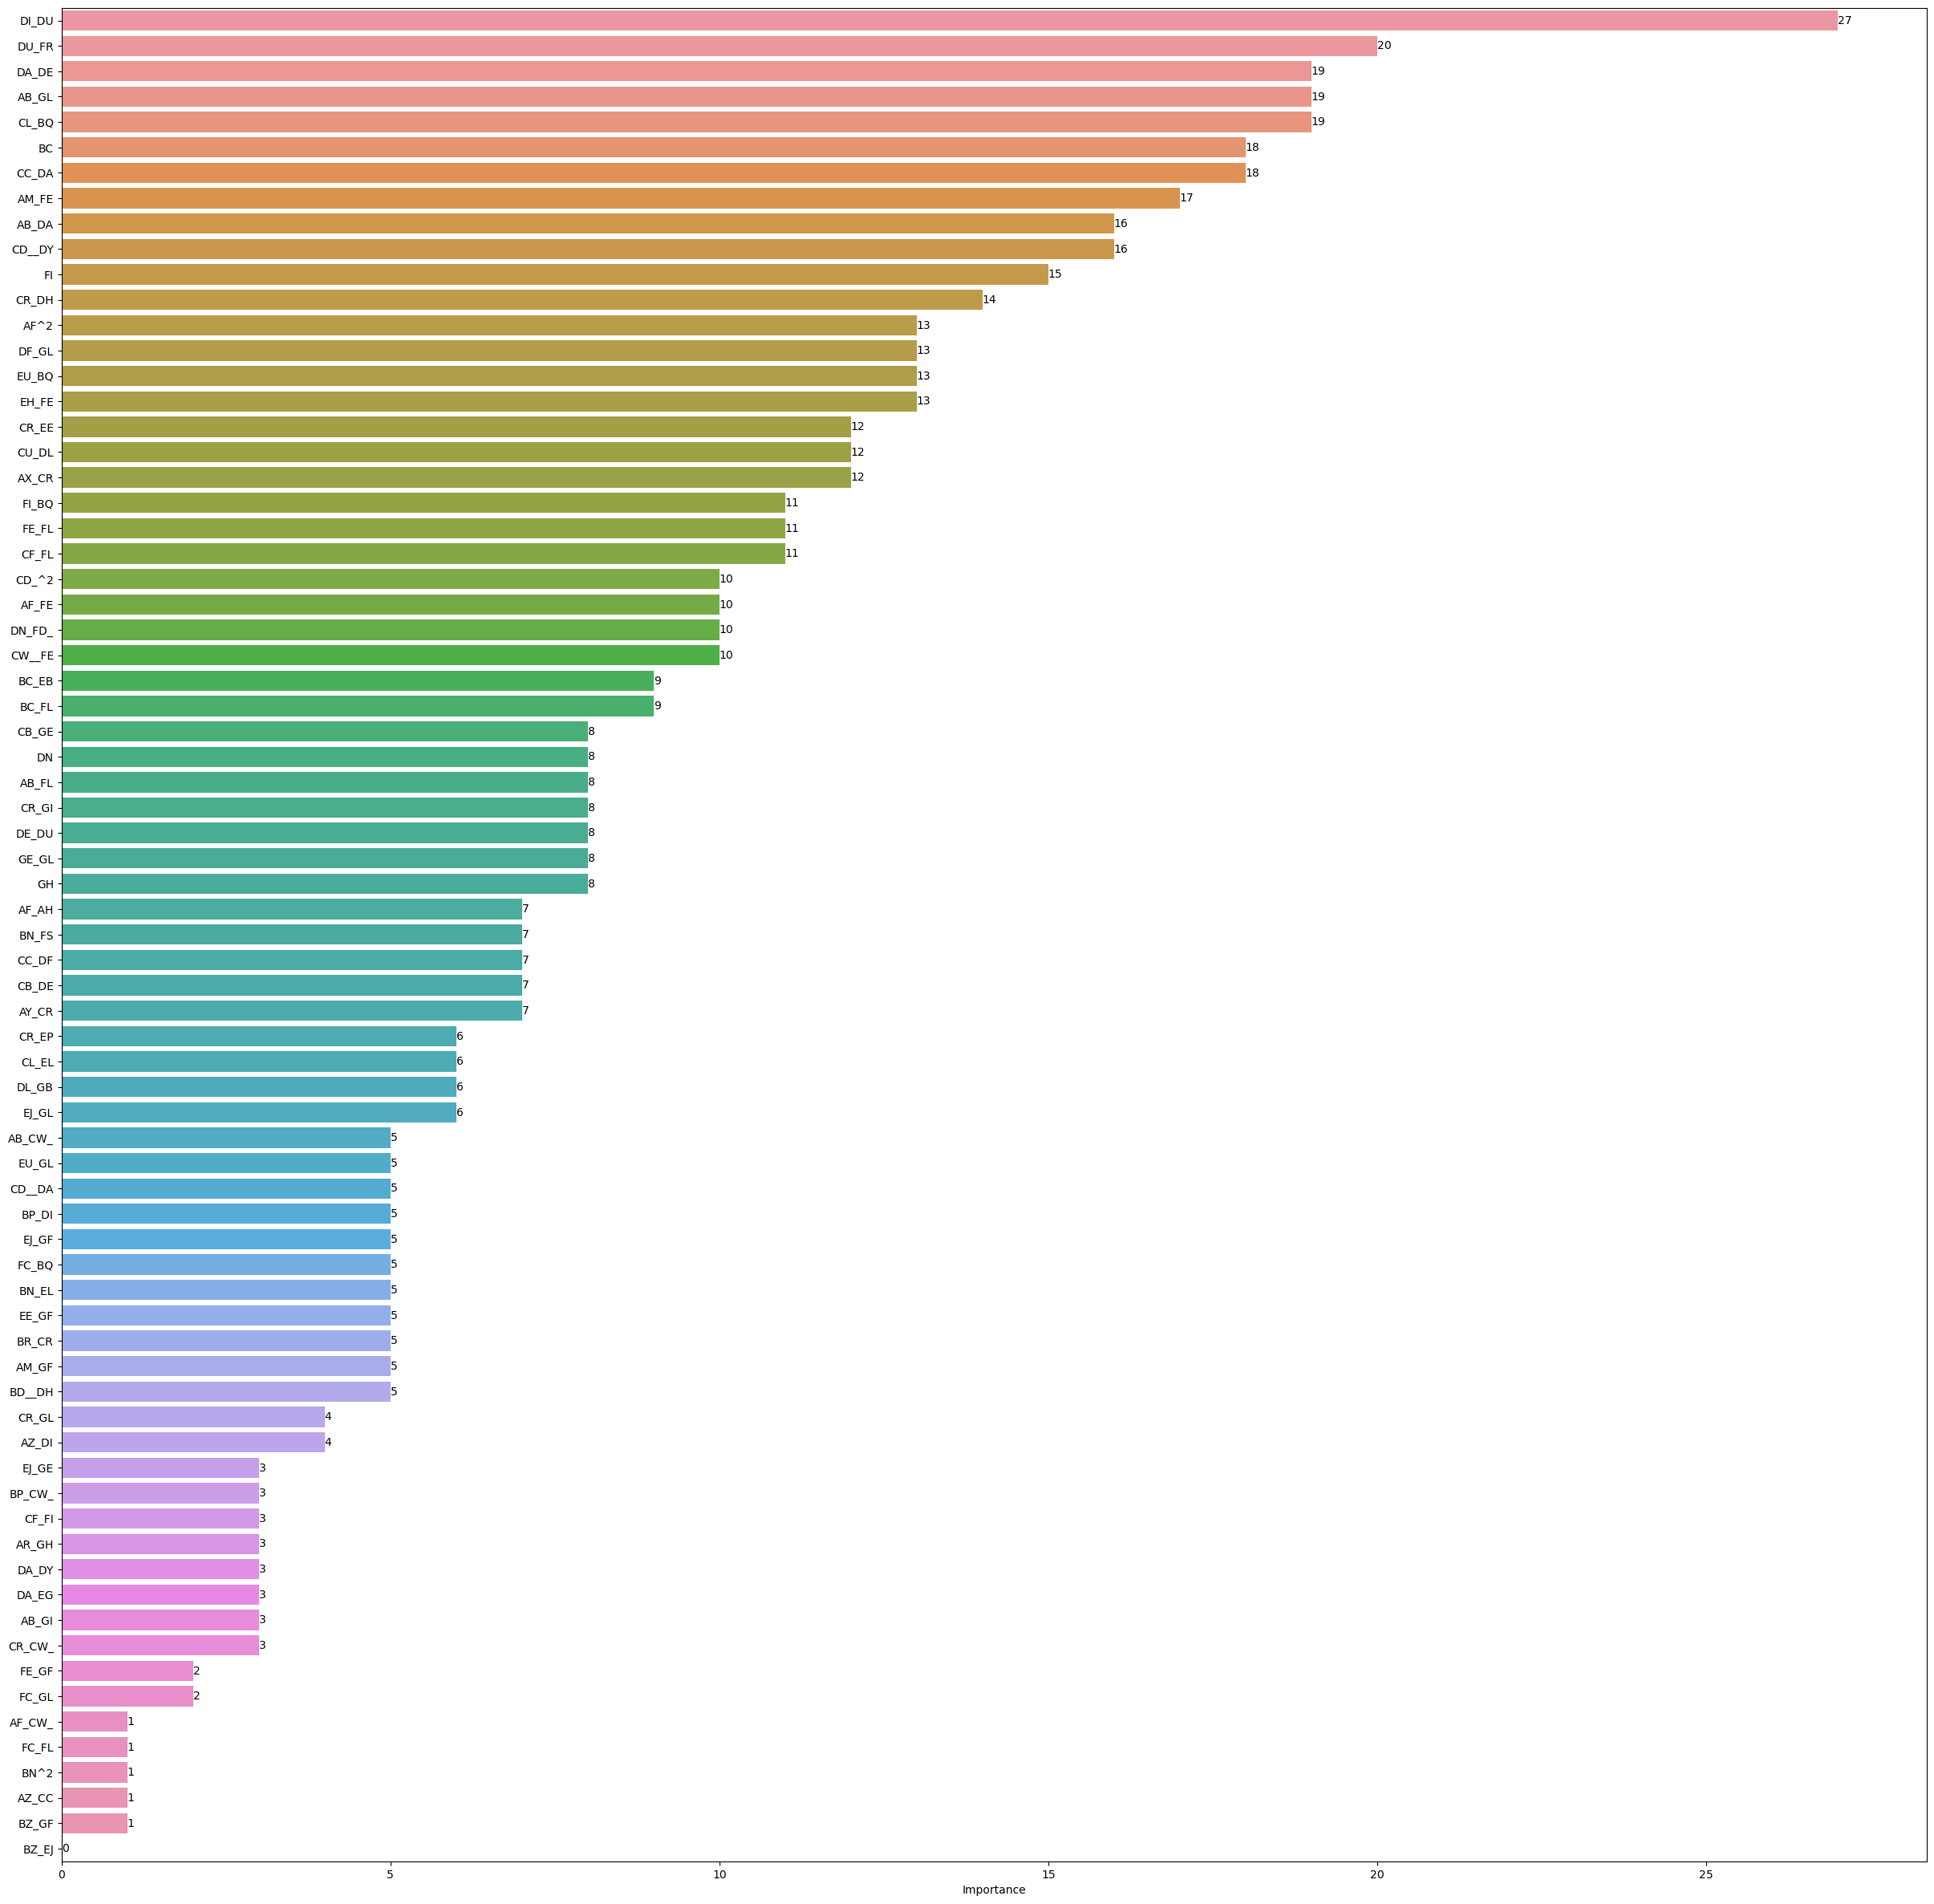

In [49]:
feat_importances = pd.DataFrame(modelLGBM_4.feature_importances_,
                                index = modelLGBM_4.feature_name_,
                                columns = ['Importance'])
plt.figure(figsize=(30, 30))
ax = sns.barplot(y = feat_importances.index, x='Importance',
              data = feat_importances.sort_values('Importance', ascending=False))
ax.bar_label(ax.containers[0])
plt.show()

In [50]:
#choosing features that have importance score higher than 5
X_new = X.iloc[:,modelLGBM_4.feature_importances_>=8]
X_new

,DI DU,DU FR,DA DE,AB GL,CL BQ,CC DA,AM FE,AB DA,CD DY,FI,...,DE DU,GE GL,BN FS,CC DF,CB DE,CR EP,CL EL,AZ DI,DA EG,AB GI
Id,,,,,,,,,,,,,,,,,,,,,
000ff2bfdfe9,473.955503,9.232900,20419.020261,0.025197,160.377449,38.927158,202183.243794,14.464475,542.304746,3.583450,...,1569.683697,8.738223,2.142825,0.134492,13957.835077,5.436029,32.430339,875.696533,99008.031857,14.621831
007255e47698,0.610146,0.002743,12641.266653,3.193008,16.434914,34.316682,250834.040295,10.285727,871.935604,10.358927,...,0.985185,1595.845943,11.048944,0.115691,5407.363681,106.654983,121.551786,1494.821753,78677.307709,4.668201
013f2bd269f5,154.841470,1.258218,22763.337155,0.092568,230.335515,35.116060,269851.615432,33.287384,3168.431371,11.626917,...,414.556454,17.450847,31.747777,0.118350,10466.844367,54.996362,114.605970,1539.672187,105810.048657,16.541614
043ac50845d5,371.282473,1.319866,9294.811574,0.039285,15.473889,33.938495,845594.376927,11.918575,4584.629131,14.852022,...,522.062030,12.842893,6.729811,0.171344,2988.817680,49.949041,44.353602,1545.579968,741831.624044,22.813981
044fb8a146ec,112.108941,55.529281,14826.259477,0.036742,157.236710,39.733597,228453.047528,28.166819,658.509792,13.666727,...,229.184376,14.116333,2.927253,0.128044,16457.346156,63.766213,114.605970,332.612909,103962.253030,13.790569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fd3dafe738fd,0.976492,0.006957,7744.715234,3.286920,32.131566,15.041090,163328.557554,3.254173,1793.272903,9.879296,...,1.963884,4772.490920,1.434928,0.164989,14724.396454,54.831455,60.782658,1512.364119,10772.602605,10.348001
fd895603f071,124.865123,0.805444,6911.151730,0.063346,361.953855,33.911847,859346.951983,19.137980,1551.009629,10.910227,...,102.041179,72.233350,11.601391,0.184334,9744.335554,87.366583,114.605970,2431.153708,75642.547531,54.397448
fd8ef6377f76,1.207891,0.002743,23352.209038,9.391199,155.544139,74.135679,281701.286976,44.704263,6784.774147,12.029366,...,1.231579,2832.895936,1.387097,0.169133,20180.752819,76.894418,163.226685,3373.141950,268393.264480,51.087740


Creating new models

In [51]:
gridLGBM_1_new = GridSearchCV(LGBMClassifier(), {'learning_rate': [0.01, 0.05, 0.1, 0.26, 0.3, 0.5, 1],
                                        'n_estimators': [50,80,100,200], 'num_leaves': [8,10,14,20,26,31],
                                       'max_depth': [-1,2,4,6,8,10]},
                                        cv=KFold(n_splits=5, shuffle=True, random_state=12), n_jobs=-1,
                        scoring='neg_log_loss', verbose=1)
gridLGBM_1_new.fit(X_new, y)
print(f'Best hyperparameters: {gridLGBM_1_new.best_params_}')

modelLGBM_1_new = LGBMClassifier(n_estimators=gridLGBM_1_new.best_params_['n_estimators'],
                        learning_rate=gridLGBM_1_new.best_params_['learning_rate'],
                        num_leaves=gridLGBM_1_new.best_params_['num_leaves'],
                        max_depth=gridLGBM_1_new.best_params_['max_depth'],
                        objective = 'binary',
                        class_weight = 'balanced',
                        random_state=12)

Fitting 5 folds for each of 1008 candidates, totalling 5040 fits
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200, 'num_leaves': 8}


In [52]:
gridLGBM_2_new = GridSearchCV(modelLGBM_1_new, {'subsample': [0.1, 0.3, 0.5, 0.7, 0.9, 1], 
                                          'colsample_bytree': [0.1, 0.3, 0.5, 0.7, 0.9, 1],
                                       'subsample_freq': [0,1,3,5,8,10]},
                          cv = KFold(n_splits=5, shuffle=True, random_state=12),
                          n_jobs=-1, scoring='neg_log_loss', verbose=1)
gridLGBM_2_new.fit(X_new, y)
print(f'Best hyperparameters: {gridLGBM_2_new.best_params_}')

modelLGBM_2_new = LGBMClassifier(n_estimators=gridLGBM_1_new.best_params_['n_estimators'],
                        learning_rate=gridLGBM_1_new.best_params_['learning_rate'],
                        num_leaves=gridLGBM_1_new.best_params_['num_leaves'],
                        max_depth=gridLGBM_1_new.best_params_['max_depth'],
                        subsample = gridLGBM_2_new.best_params_['subsample'],
                        colsample_bytree = gridLGBM_2_new.best_params_['colsample_bytree'],
                        subsample_freq = gridLGBM_2_new.best_params_['subsample_freq'],
                        objective = 'binary',
                        class_weight = 'balanced',
                        random_state=12)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best hyperparameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'subsample_freq': 10}


In [53]:
gridLGBM_3_new = GridSearchCV(modelLGBM_2_new, {'min_split_gain': [0, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 1],
                                          'min_child_weight' : [0.0005, 0.001, 0.005, 0.01, 0.03, 0.05, 0.1],
                                          'min_child_samples':[5,10,15,20, 25,30]},
                          cv = KFold(n_splits=5, shuffle=True, random_state=12),
                          n_jobs=-1, scoring='neg_log_loss', verbose=1)
gridLGBM_3_new.fit(X_new, y)
print(f'Best hyperparameters: {gridLGBM_3_new.best_params_}')

modelLGBM_3_new = LGBMClassifier(n_estimators=gridLGBM_1_new.best_params_['n_estimators'],
                        learning_rate=gridLGBM_1_new.best_params_['learning_rate'],
                        num_leaves=gridLGBM_1_new.best_params_['num_leaves'],
                        max_depth=gridLGBM_1_new.best_params_['max_depth'],
                        subsample = gridLGBM_2_new.best_params_['subsample'],
                        colsample_bytree = gridLGBM_2_new.best_params_['colsample_bytree'],
                        subsample_freq = gridLGBM_2_new.best_params_['subsample_freq'], 
                        min_split_gain = gridLGBM_3_new.best_params_['min_split_gain'],
                        min_child_weight = gridLGBM_3_new.best_params_['min_child_weight'],
                        min_child_samples = gridLGBM_3_new.best_params_['min_child_samples'],
                        objective = 'binary',
                        class_weight = 'balanced',
                        random_state=12)

Fitting 5 folds for each of 336 candidates, totalling 1680 fits
Best hyperparameters: {'min_child_samples': 20, 'min_child_weight': 0.0005, 'min_split_gain': 0.1}


In [54]:
gridLGBM_4_new = GridSearchCV(modelLGBM_3_new, {'reg_lambda': [0, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 1],
                                          'reg_alpha' : [0, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 1]},
                          cv = KFold(n_splits=5, shuffle=True, random_state=12),
                          n_jobs=-1, scoring='neg_log_loss', verbose=1)
gridLGBM_4_new.fit(X_new, y)
print(f'Best hyperparameters: {gridLGBM_4_new.best_params_}')

modelLGBM_4_new = LGBMClassifier(n_estimators=gridLGBM_1_new.best_params_['n_estimators'],
                        learning_rate=gridLGBM_1_new.best_params_['learning_rate'],
                        num_leaves=gridLGBM_1_new.best_params_['num_leaves'],
                        max_depth=gridLGBM_1_new.best_params_['max_depth'],
                        subsample = gridLGBM_2_new.best_params_['subsample'],
                        colsample_bytree = gridLGBM_2_new.best_params_['colsample_bytree'],
                        subsample_freq = gridLGBM_2_new.best_params_['subsample_freq'],
                        min_split_gain = gridLGBM_3_new.best_params_['min_split_gain'],
                        min_child_weight = gridLGBM_3_new.best_params_['min_child_weight'],
                        min_child_samples = gridLGBM_3_new.best_params_['min_child_samples'],
                        reg_lambda = gridLGBM_4_new.best_params_['reg_lambda'],
                        reg_alpha = gridLGBM_4_new.best_params_['reg_alpha'],
                        objective = 'binary',
                        class_weight = 'balanced',
                        random_state=12)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best hyperparameters: {'reg_alpha': 0.05, 'reg_lambda': 0.1}


In [55]:
modelLGBM_4_new.fit(X_new, y)

results_lgbm_new = cross_val_score(modelLGBM_4_new, X_new, y, cv=10, n_jobs=-1, scoring=bll).mean()
results_lgbm_acc_new = cross_val_score(modelLGBM_4_new, X_new, y, cv=10, n_jobs=-1, scoring='accuracy').mean()

print(f'LGBM: bll = {results_lgbm_new}, accuracy = {results_lgbm_acc_new}')

LGBM: bll = -0.13543366179205857, accuracy = 0.9465362242199895


In [56]:
test_sel=test_poly[out1]
test_sel_new=test_sel.iloc[:,modelLGBM_4.feature_importances_>=8]
test_sel_new

,DI DU,DU FR,DA DE,AB GL,CL BQ,CC DA,AM FE,AB DA,CD DY,FI,...,DE DU,GE GL,BN FS,CC DF,CB DE,CR EP,CL EL,AZ DI,DA EG,AB GI
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
pred = modelLGBM_4_new.predict_proba(test_sel_new)
submission=test[['Id']]
submission['class_0']=pred[:,0]
submission['class_1']=pred[:,1]
submission

,Id,class_0,class_1
0,00eed32682bb,0.646699,0.353301
1,010ebe33f668,0.646699,0.353301
2,02fa521e1838,0.646699,0.353301
3,040e15f562a2,0.646699,0.353301
4,046e85c7cc7f,0.646699,0.353301


In [58]:
submission.to_csv("/kaggle/working/submission.csv",index=False)